# 特徴量エンジニアリング概要

## 本プロジェクトの目的

機械学習のパフォーマンス改善に向けて重要な特徴量エンジニアリングの手法を，実装例を交えて紹介する．  
主に特徴量エンジニアリングについて述べるが，一部特徴量選択についても触れる．

## 特徴量エンジニアリングとは

機械学習における特徴量とは，分析対象を測定することが可能な変数を指す．データセットでは特徴量は列として表記されることが多い．

データセットに含める特徴量の質が，機械学習モデルの精度に影響し，ひいては機械学習を活用する場合に得るインサイトの質に大きく影響する．

データセットの質を改善する為に，特徴量選択や特徴量エンジニアリングが実施される．  
特徴量選択は分析対象に関連する特徴量に重点を置き，無関係な特徴量を取り除くプロセスを指す．特徴量エンジニアリングは，既存の特徴量をもとに新たな特徴量を構築してデータセットに追加することを指す．

## 特徴量選択と特徴量エンジニアリングの具体例

特徴エンジニアリングの手法の詳細は他のNotebookに記載するが，本節では特徴量選択と特徴量エンジニアリングの違いを説明する為の具体例を示す．

データセットはFlood Modeling Datasetを使用し，論文[Time Series Extrinsic Regression](https://arxiv.org/abs/2006.12672)のSVR Optimisedの条件に対してtsfreshによる特徴量選択及び特徴量エンジニアリングを試行する．

学習パラメータは論文通り，下記パラメータに対して3-Folds Cross ValidationのGridSearchのベストモデルを採用する．

|Parameters|Values|
|:--|:--|
|Kernel|RBF, Sigmoid|
|gamma|0.001, 0.01, 0.1, 1|
|C|0.1, 1, 10, 100|


### 実装例

In [1]:
# --- ローカルモジュールの更新を自動で読み込む ---
%load_ext autoreload
%autoreload 2

In [16]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from lib.dataloader.flood_modeling import load_flood_modeling

#### データセットダウンロード

In [12]:
if (not os.path.exists("flood_modeling_datasets")):
    !mkdir -p "flood_modeling_datasets" ; \
        cd flood_modeling_datasets ; \
        wget "https://zenodo.org/record/3902694/files/FloodModeling1_TEST.ts" ; \
        wget "https://zenodo.org/record/3902694/files/FloodModeling1_TRAIN.ts" ; \
        ls
else:
    print('[INFO] Dataset flood_modeling_datasets is already exist')

--2021-09-05 04:15:17--  https://zenodo.org/record/3902694/files/FloodModeling1_TEST.ts
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 380100 (371K) [application/octet-stream]
Saving to: ‘FloodModeling1_TEST.ts’

FloodModeling1_TEST 100%[===================>] 371.19K   338KB/s    in 1.1s    

2021-09-05 04:15:20 (338 KB/s) - ‘FloodModeling1_TEST.ts’ saved [380100/380100]

--2021-09-05 04:15:20--  https://zenodo.org/record/3902694/files/FloodModeling1_TRAIN.ts
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 882160 (861K) [application/octet-stream]
Saving to: ‘FloodModeling1_TRAIN.ts’

FloodModeling1_TRAI 100%[===================>] 861.48K   557KB/s    in 1.5s    

2021-09-05 04:15:24 (557 KB/s) - ‘FloodModeling1_TRAIN.ts’ saved [882

In [39]:
train_ts = os.path.join('flood_modeling_datasets', 'FloodModeling1_TRAIN.ts')
test_ts = os.path.join('flood_modeling_datasets', 'FloodModeling1_TEST.ts')
x_train, y_train, x_test, y_test = load_flood_modeling(train_ts, test_ts)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(471, 266)
(471,)
(202, 266)
(202,)


このデータセットは統計量や自己回帰モデルの係数が説明変数で姿勢がカテゴリのテーブルデータである．

#### アクティビティの分布確認

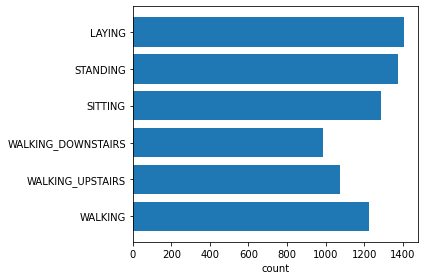

In [5]:
plt.figure()

barh_y = [activity_name[_i] for _i in range(1, 7)]
barh_width = [len(y_train[y_train==_i]) for _i in range(1, 7)]

plt.barh(barh_y, barh_width)
plt.xlabel('count')
plt.tight_layout()
plt.show()

plt.close()

In [6]:
params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 4, 6, 8]
}
dt_clf = GridSearchCV(tree.DecisionTreeClassifier(), params, cv=5)
dt_clf.fit(x_train, y_train)

print('[INFO] Best params: {}'.format(dt_clf.best_params_))
print('[INFO] Best score: {}'.format(dt_clf.best_score_))

[INFO] Best params: {'criterion': 'entropy', 'max_depth': 8}
[INFO] Best score: 0.8546018488972749


In [7]:
prediction = dt_clf.predict(x_test)
print(prediction.shape)

(2947,)


In [8]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           1       0.81      0.90      0.85       496
           2       0.82      0.73      0.77       471
           3       0.84      0.83      0.84       420
           4       0.80      0.78      0.79       491
           5       0.80      0.82      0.81       532
           6       1.00      1.00      1.00       537

    accuracy                           0.85      2947
   macro avg       0.85      0.84      0.84      2947
weighted avg       0.85      0.85      0.85      2947



## Reference

* [特徴量変数](https://www.datarobot.com/jp/wiki/feature/)
* [特徴量の選択](https://www.datarobot.com/jp/wiki/feature-selection/)
* [特徴量エンジニアリング](https://www.datarobot.com/jp/wiki/feature-engineering/)
* [データインサイト](https://www.datarobot.com/jp/wiki/insights/)
* [Awesome Public Datasets](https://github.com/awesomedata/awesome-public-datasets)
* [Feature-Engineeringのリンク集めてみた](https://qiita.com/squash/items/667f8cda16c76448b0f4)
* [DataFrameで特徴量作るのめんどくさ過ぎる。。featuretoolsを使って自動生成したろ](https://qiita.com/Hyperion13fleet/items/4eaca365f28049fe11c7)
* [時系列データから自動で特徴抽出するライブラリ tsfresh](https://qiita.com/yuko1658/items/871df86f99a9134cc9ef)
* [特徴量選択のまとめ](https://qiita.com/shimopino/items/5fee7504c7acf044a521)
* [機械学習で特徴量を正しく選択する方法](https://rightcode.co.jp/blog/information-technology/feature-selection-right-choice)
* [特徴選択とは？機械学習の予測精度を改善させる必殺技「特徴選択」を理解しよう](https://www.codexa.net/feature-selection-methods/)
* [Human Activity Recognition Using Smartphones Data Set](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones)
* [Human Activity Recognition using Smartphone](https://arxiv.org/abs/1401.8212)
* [Human Activity Analysis and Recognition from
Smartphones using Machine Learning Techniques](https://arxiv.org/abs/2103.16490)
* [Human Activity Recognition using Machine Learning](https://github.com/sushantdhumak/Human-Activity-Recognition-with-Smartphones)
* [How to Choose a Feature Selection Method For Machine Learning](https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/)
* [統計分析を理解しよう-よく使われている統計分析方法の概要-](https://www.nli-research.co.jp/report/detail/id=61928?site=nli)
* [Monash, UEA & UCR Time Series Extrinsic Regression Repository](http://tseregression.org/)
* [Flood Modeling Dataset 1](https://zenodo.org/record/3902694#.YTQjG50zaUk)
* [Flood Modeling Dataset 2](https://zenodo.org/record/3902696#.YTQktZ0zaUk)
* [Flood Modeling Dataset 3](https://zenodo.org/record/3902698#.YTQktZ0zaUk)
* [Monash University, UEA, UCR Time Series Extrinsic Regression Archive](https://arxiv.org/abs/2006.10996)
* [Time Series Extrinsic Regression](https://arxiv.org/abs/2006.12672)
* [ChangWeiTan/TS-Extrinsic-Regression](https://github.com/ChangWeiTan/TS-Extrinsic-Regression)